<a href="https://colab.research.google.com/github/Soeryadana/it-cert-automation-practice/blob/master/Air_Quality_Forecast_in_Jakarta_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing Tensorflow**

In [1]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 3.5 MB/s 
     |████████████████████████████████| 40 kB 6.9 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import tensorflow as tf

In [3]:
print(tf.__version__)

2.8.2


## **Importing Libraries and Preparing Plot Series**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("ISPU")
  plt.grid(True)  

## **Uploading DataSet**

Source Dataset: https://data.jakarta.go.id/organization/badan-pengelolaan-lingkungan-hidup-daerah?q=ispu&sort=1

This dataset contains air pollution measurements, such as Particulate Matter (PM10), Sulfur Dioxide (SO2), Carbon Monoxide (CO), Ozone (O3), and Natrium Dioxide (NO2) from several Air Quality Monitoring Sistem (SPKU). The measurement has been converted to pollutant standards index (PSI) or Indeks Standar Pencemaran Udara (ISPU)

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [10]:
df = pd.read_csv('drive/MyDrive/Capstone Dataset/AQI_DKI_Jakarta_2010-2021.csv')

df.head()

,tanggal,pm10,so2,co,o3,no2,max,critical,categori,lokasi_spku,Unnamed: 10
0,2010-01-01,60,4,73,27,14,73,CO,SEDANG,DKI1,NaN
1,2010-01-02,32,2,16,33,9,33,O3,BAIK,DKI1,NaN
2,2010-01-03,27,2,19,20,9,27,PM10,BAIK,DKI1,NaN
3,2010-01-04,22,2,16,15,6,22,PM10,BAIK,DKI1,NaN
4,2010-01-05,25,2,17,15,8,25,PM10,BAIK,DKI1,NaN


## **Preprocessing Data**

In [11]:
new_data = []
for index,data in enumerate(df['max']):
  new_data.append([index+1,data])

In [13]:
new_df = pd.DataFrame(new_data, columns = ['No', 'Max'])
new_df.head()

,No,Max
0,1,73
1,2,33
2,3,27
3,4,22
4,5,25


In [15]:
jumlah = len(new_df)
jumlah

4363

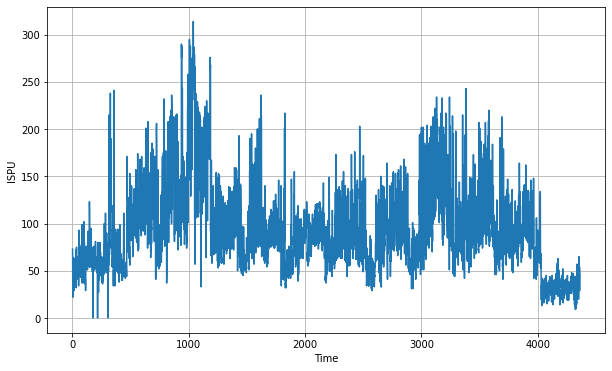

In [16]:
time = np.array(new_df['No'].values.tolist())
series = np.array(new_df['Max'].values.tolist())

plt.figure(figsize=(10, 6))
plot_series(time, series)

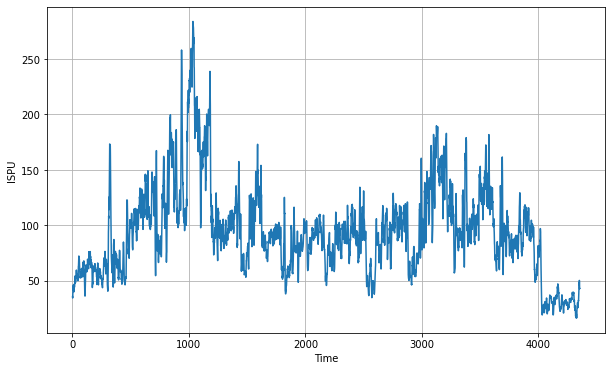

In [27]:
series_averages_window = 7
i = 0

series_moving_averages = []
while i < len(series) - series_averages_window + 1:
  window_average = round(np.sum(series[i:i+series_averages_window]) / series_averages_window, 2)
  series_moving_averages.append(window_average)
  i += 1

moving_averages_time = time[:4357]
moving_averages_series = np.array(series_moving_averages)

plt.figure(figsize=(10, 6))
plot_series(moving_averages_time, moving_averages_series)

In [35]:
print(moving_averages_time.shape)
print(moving_averages_series.shape)

(4357,)
(4357,)


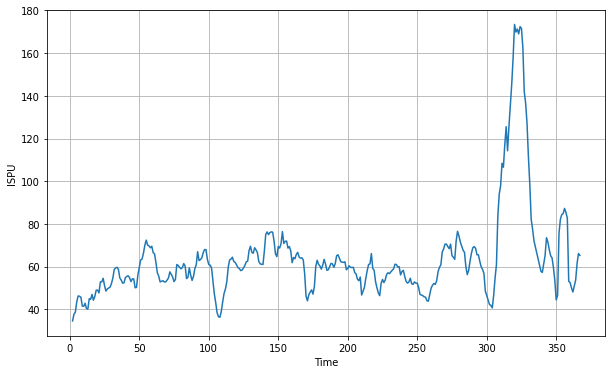

In [36]:
def zoomed_plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[1:367], series[1:367], format)
  plt.xlabel("Time")
  plt.ylabel("ISPU")
  plt.grid(True) 

plt.figure(figsize=(10, 6))
zoomed_plot_series(moving_averages_time, moving_averages_series)

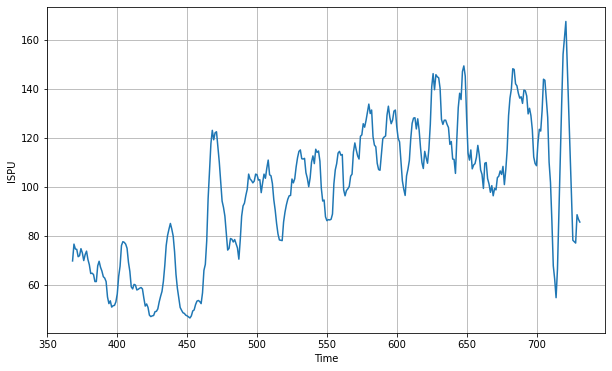

In [37]:
def zoomed_plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[367:731], series[367:731], format)
  plt.xlabel("Time")
  plt.ylabel("ISPU")
  plt.grid(True) 

plt.figure(figsize=(10, 6))
zoomed_plot_series(moving_averages_time, moving_averages_series)

## **Preparing Dataset for Training and Testing**

In [38]:
split_time = int(0.9 * jumlah)
time_train = moving_averages_time[:split_time]
x_train = moving_averages_series[:split_time]
time_valid = moving_averages_time[split_time:]
x_valid = moving_averages_series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [39]:
print(time_train.shape)
print(x_train.shape)
print(time_valid.shape)
print(x_valid.shape)

(3926,)
(3926,)
(431,)
(431,)


## **Windowing Dataset**

In [40]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## **Training The Dataset**

In [41]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.summary()

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 68,575
Trainable params: 68,575
Non-traina

In [42]:
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9))


In [43]:
history = model.fit(dataset,epochs=100,callbacks = [lr_schedule])


Epoch 1/100
122/122 [==============================] - 17s 11ms/step - loss: 100.2977 - lr: 1.0000e-08
Epoch 2/100
122/122 [==============================] - 1s 10ms/step - loss: 100.2973 - lr: 1.1220e-08
Epoch 3/100
122/122 [==============================] - 1s 10ms/step - loss: 100.2970 - lr: 1.2589e-08
Epoch 4/100
122/122 [==============================] - 1s 10ms/step - loss: 100.2966 - lr: 1.4125e-08
Epoch 5/100
122/122 [==============================] - 1s 10ms/step - loss: 100.2961 - lr: 1.5849e-08
Epoch 6/100
122/122 [==============================] - 1s 10ms/step - loss: 100.2957 - lr: 1.7783e-08
Epoch 7/100
122/122 [==============================] - 1s 10ms/step - loss: 100.2951 - lr: 1.9953e-08
Epoch 8/100
122/122 [==============================] - 1s 10ms/step - loss: 100.2945 - lr: 2.2387e-08
Epoch 9/100
122/122 [==============================] - 1s 10ms/step - loss: 100.2938 - lr: 2.5119e-08
Epoch 10/100
122/122 [==============================] - 1s 10ms/step - loss: 100.

(1e-08, 0.001, 0.0, 100.0)

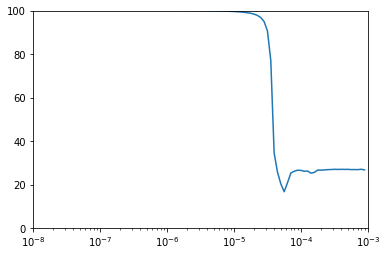

In [45]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 100])

In [48]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(learning_rate=5e-5, momentum=0.9), metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
122/122 [==============================] - 5s 11ms/step - loss: 99.3407 - mae: 99.8407
Epoch 2/500
122/122 [==============================] - 1s 11ms/step - loss: 97.7781 - mae: 98.2781
Epoch 3/500
122/122 [==============================] - 1s 10ms/step - loss: 94.3155 - mae: 94.8155
Epoch 4/500
122/122 [==============================] - 2s 17ms/step - loss: 80.8804 - mae: 81.3803
Epoch 5/500
122/122 [==============================] - 2s 15ms/step - loss: 32.5754 - mae: 33.0711
Epoch 6/500
122/122 [==============================] - 1s 11ms/step - loss: 25.6275 - mae: 26.1226
Epoch 7/500
122/122 [==============================] - 1s 10ms/step - loss: 21.4445 - mae: 21.9388
Epoch 8/500
122/122 [==============================] - 1s 11ms/step - loss: 18.1009 - mae: 18.5931
Epoch 9/500
122/122 [==============================] - 1s 11ms/step - loss: 16.6257 - mae: 17.1183
Epoch 10/500
122/122 [==============================] - 1s 10ms/step - loss: 15.8084 - mae: 16.2996
Epoch 11/

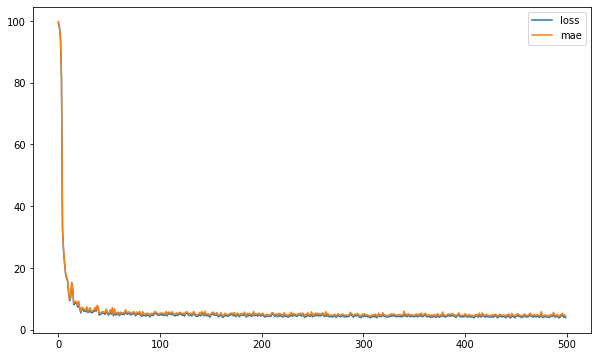

In [49]:
pd.DataFrame(history.history).plot(figsize=(10,6))

## **Forecasting**

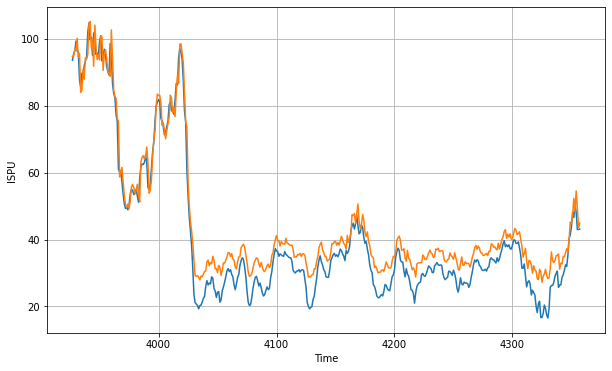

In [50]:
forecast=[]
for moving_averages_time in range(len(moving_averages_series) - window_size):
  forecast.append(model.predict(moving_averages_series[moving_averages_time:moving_averages_time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

## **Mean Absolute Error**

In [51]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7615166

## **Predict**

In [52]:
print(moving_averages_series[700:730])
model.predict(moving_averages_series[700:730][np.newaxis])

[117.71 123.43 122.71 131.   143.86 143.43 136.   128.29 110.   101.71
  86.    67.71  62.29  54.71  66.43  89.   112.43 133.71 154.   160.57
 167.43 149.86 132.71 114.86  96.71  78.14  77.57  77.    88.57  86.71]


array([[87.25721]], dtype=float32)

In [53]:
model.save("AQI_Forecast_V2_Model.h5")

In [56]:
!tensorflowjs_converter --input_format keras \
                       AQI_Forecast_V2_Model.h5 \
                       content/